In [1]:
import csv
import datetime as dt
from datetime import date
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from linearmodels.panel import PanelOLS
from sklearn.cluster import KMeans

In [4]:
file_location = 'C:\\Users\\Tan\\Desktop\\GA\\Capstone\\know_customer_monthly.csv'

In [5]:
f = pd.read_csv(file_location)

In [6]:
df = pd.DataFrame(f)

In [7]:
df['dateindex'] = pd.to_datetime(df['trans_date'], format='%Y-%m-%d')
df.set_index('dateindex', inplace=True, drop=True)
df.index = df.index.to_period('M').to_timestamp('M')

In [8]:
df.head(5)

,id,invoices_no,categories,quantity,unitprice,gross,days_since_last,trans_90d,revenue_90d,avg_revenue_90d,trans_date,frequency,monetary,monetary_avg,recency,rfm_equal
dateindex,,,,,,,,,,,,,,,,
2011-03-31,12747.0,1,12.0,146,3.106667,310.78,40.0,3.0,1009.31,336.436667,2011-03-01,2,2,2,1,5
2011-03-31,12823.0,1,1.0,60,7.650000,459.00,35.0,2.0,535.50,267.750000,2011-03-30,2,2,2,1,5
2011-03-31,13069.0,1,48.0,398,1.771667,273.98,48.0,2.0,595.97,297.985000,2011-03-24,2,2,2,1,5
2011-03-31,13842.0,1,19.0,115,5.070526,311.07,36.0,2.0,596.96,298.480000,2011-03-11,2,2,2,1,5
2011-03-31,13911.0,1,18.0,208,2.452222,282.28,34.0,2.0,559.27,279.635000,2011-03-20,2,2,2,1,5


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7892 entries, 2011-03-31 to 2011-12-31
Data columns (total 16 columns):
id                 7892 non-null float64
invoices_no        7892 non-null int64
categories         7892 non-null float64
quantity           7892 non-null int64
unitprice          7892 non-null float64
gross              7892 non-null float64
days_since_last    7892 non-null float64
trans_90d          7892 non-null float64
revenue_90d        7892 non-null float64
avg_revenue_90d    7892 non-null float64
trans_date         7892 non-null object
frequency          7892 non-null int64
monetary           7892 non-null int64
monetary_avg       7892 non-null int64
recency            7892 non-null int64
rfm_equal          7892 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 1.0+ MB


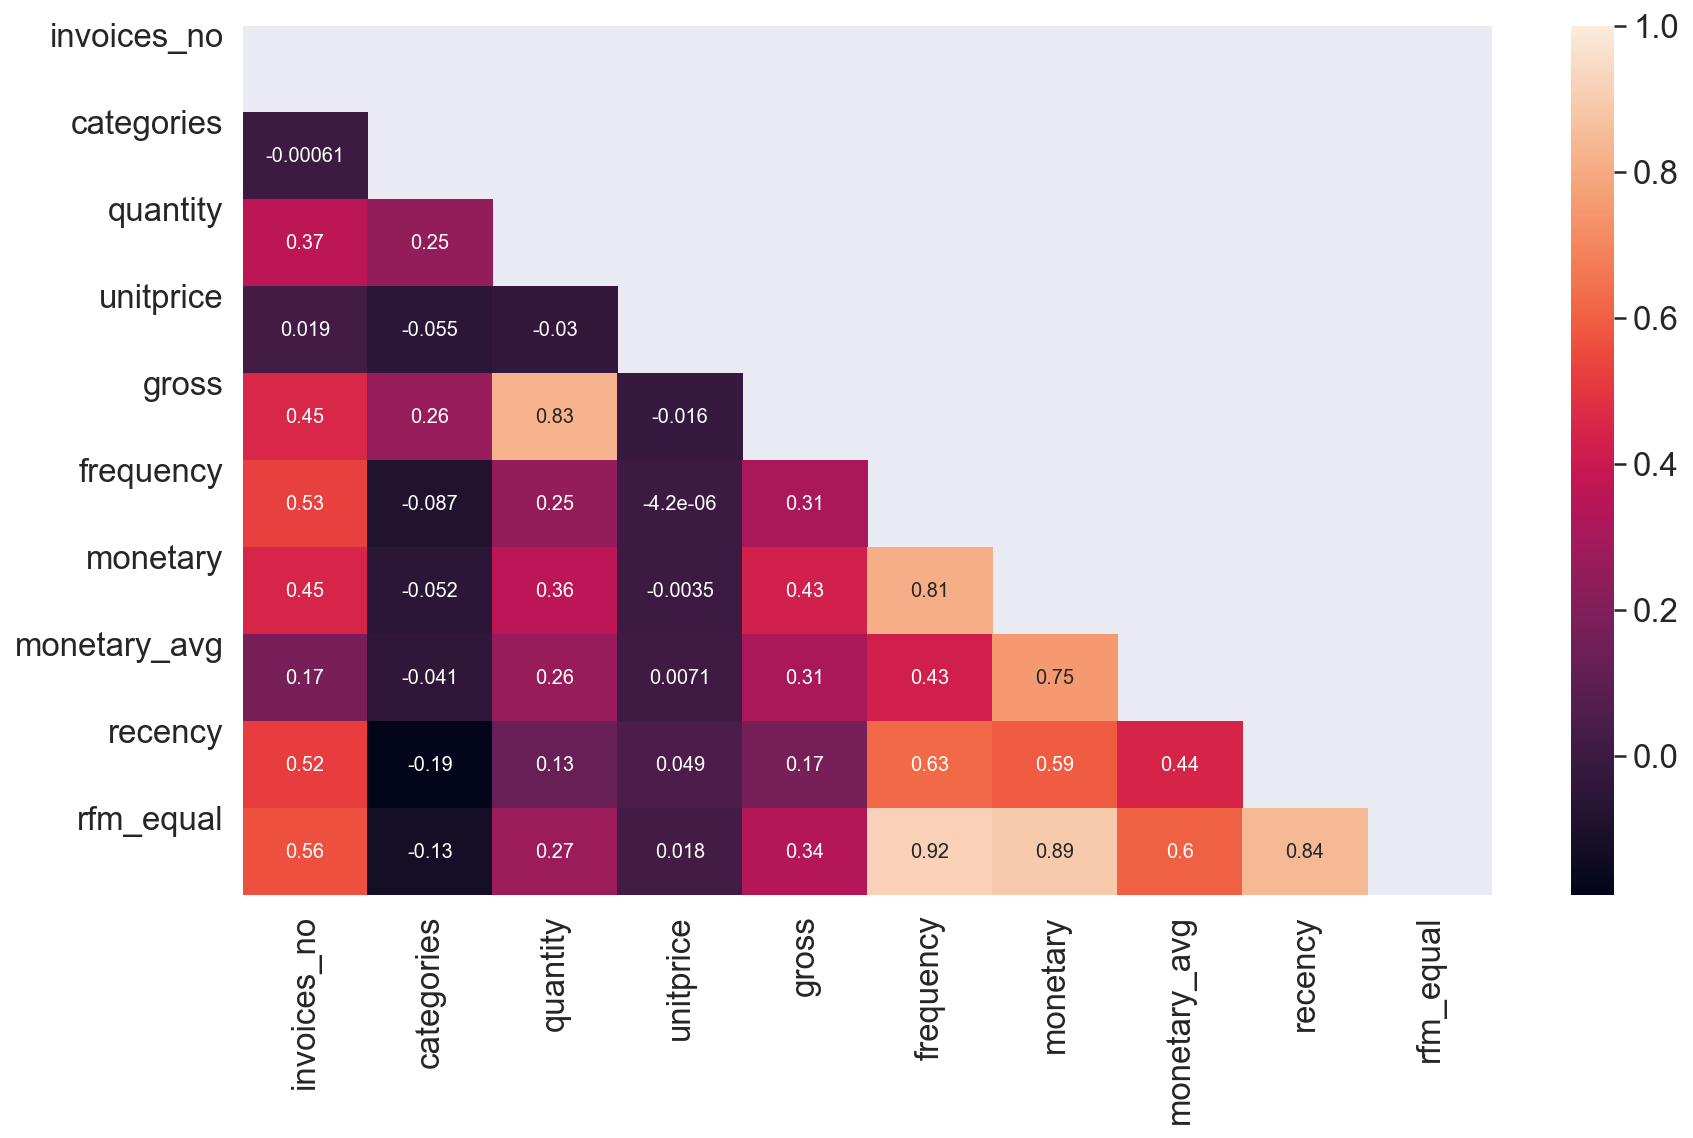

In [10]:
# The transformed RFM variables show similar strong positive correlations to the resultant "rfm_score" and "cust_class"
M = df[['invoices_no', 'categories', 'quantity', 'unitprice', 'gross', 'frequency', 'monetary', 'monetary_avg', 
        'recency', 'rfm_equal']]

fig, ax = plt.subplots(figsize=(14, 8))

mask = np.zeros_like(M.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(M.corr(), mask=mask, annot=True, ax=ax)
ax.set_yticks(np.arange(0, df.shape[1])+0.1)
ax.set_ylim([M.shape[1], 0])
plt.show()

# Transforming the "gross" target variable

In [11]:
df[['gross', 'invoices_no']].describe()

,gross,invoices_no
count,7892.000000,7892.000000
mean,459.108215,1.548784
std,547.206488,0.942002
min,-1000.370000,1.000000
25%,170.520000,1.000000
50%,318.320000,1.000000
75%,553.620000,2.000000
max,5540.540000,6.000000


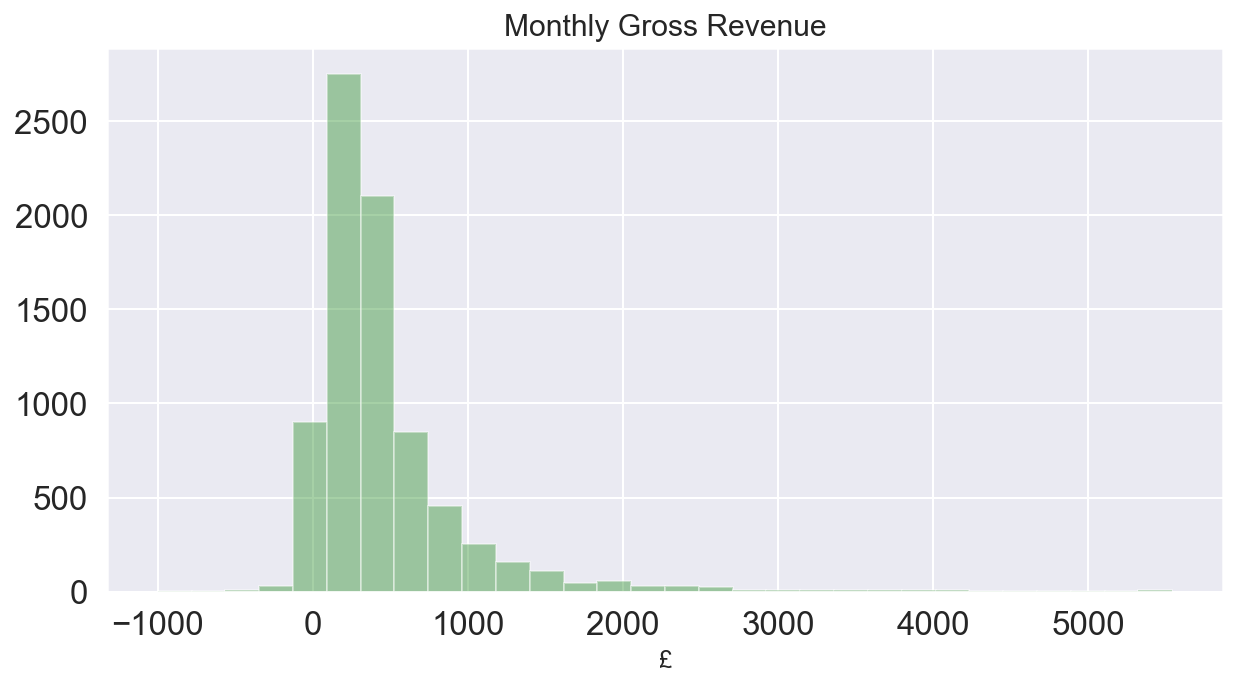

In [12]:
# Distribution of "gross" is decidedly not symmetrical, much less close to normality
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df.gross, bins=30, kde=False, ax=ax, color='forestgreen')
plt.title('Monthly Gross Revenue', fontsize=15)
plt.xlabel('£', fontsize=12);

In [13]:
df.gross[df.gross <= 0].count()

639

In [14]:
# The existence of negative observations preclude taking the natural log, so instead I take the cube root to transform "gross"
df['gross_cubic'] = np.cbrt(df.gross)

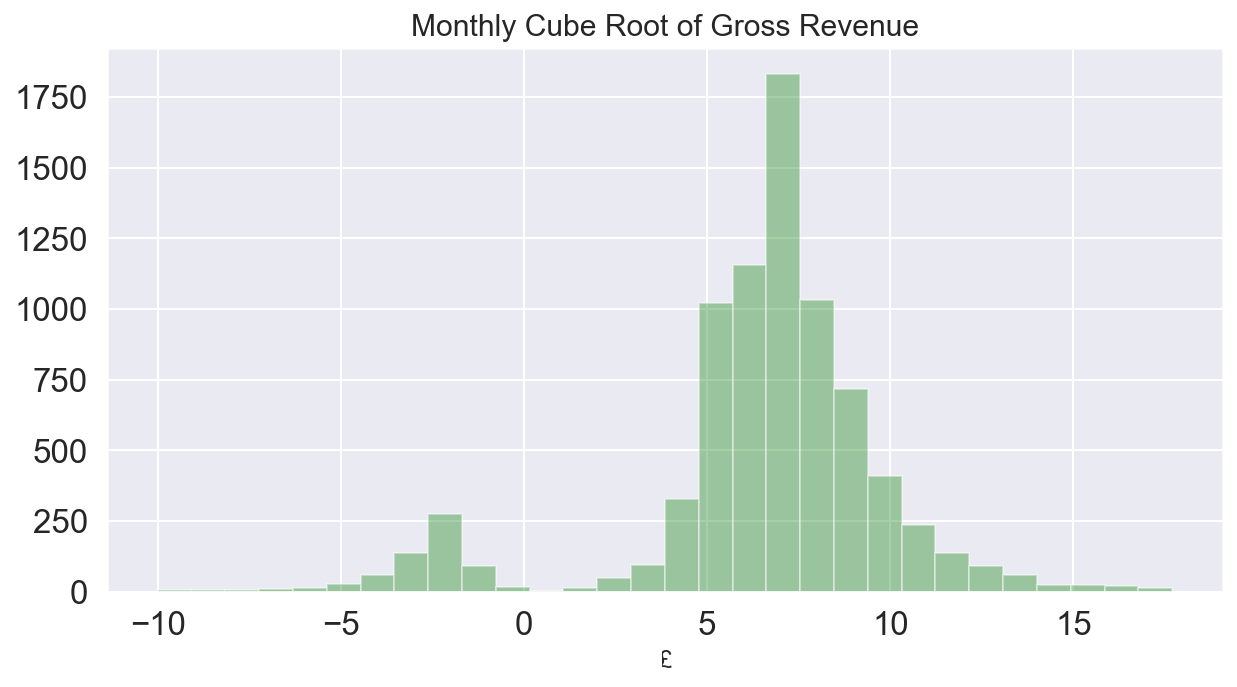

In [15]:
# The cube root of "gross" is much more symmetrical, though a bit bimodal
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df.gross_cubic, bins=30, kde=False, ax=ax, color='forestgreen')
plt.title('Monthly Cube Root of Gross Revenue', fontsize=15)
plt.xlabel('£', fontsize=12);

In [16]:
# Creating month dummies
df['month'] = df.index.month

In [17]:
df = df.sort_index()

# Using FE model to derive the weights

In [18]:
# Use the first half of the dataset as the training set to generate the coefficient weights...
# then use the second half of the dataset as the test set for hypothesis testing. 
# Need to be done manually to ensure the monthly sorting is correct
df_upper = df[:3947]

In [19]:
X = df_upper[['id', 'month', 'gross_cubic', 'frequency', 'monetary_avg', 'recency']]

In [20]:
# Ensure that each "id" has at least two observations in the dataset
countdf = X.groupby('id').count()
X = X.loc[X['id'].isin(countdf[countdf['gross_cubic'] >= 2].index)]

In [21]:
X.shape

(3217, 6)

In [22]:
X

,id,month,gross_cubic,frequency,monetary_avg,recency
dateindex,,,,,,
2011-03-31,12747.0,3,6.773571,2,2,1
2011-03-31,17965.0,3,6.793853,3,1,1
2011-03-31,13148.0,3,7.173164,3,1,1
2011-03-31,14426.0,3,9.261505,3,1,1
2011-03-31,17213.0,3,-1.846915,3,1,1
...,...,...,...,...,...,...
2011-08-31,17869.0,8,4.894037,0,0,0
2011-08-31,13394.0,8,6.744971,1,2,1
2011-08-31,15856.0,8,11.655089,3,2,4


In [23]:
X = X.set_index(['id', 'month'])

In [24]:
features = sm.add_constant(X[['frequency', 'monetary_avg', 'recency']])

C:\Users\Tan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [25]:
fe_mod = PanelOLS(X.gross_cubic, features, entity_effects=True, time_effects=False)
fe_reg_ini = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [26]:
# "frequency" and "monetary" are statistically significant at the 95% confidence level, and "recency" at the 90% level
fe_reg_ini

Dep. Variable:,gross_cubic,R-squared:,0.0607
Estimator:,PanelOLS,R-squared (Between):,-0.2463
No. Observations:,3217,R-squared (Within):,0.0607
Date:,"Wed, Jan 08 2020",R-squared (Overall):,-0.0959
Time:,17:58:55,Log-likelihood,-7249.9
Cov. Estimator:,Clustered,,
,,F-statistic:,47.231
Entities:,1023,P-value,0.0000
Avg Obs:,3.1447,Distribution:,"F(3,2191)"
Min Obs:,2.0000,,
Max Obs:,6.0000,F-statistic (robust):,30.376


# Hypothesis testing on composite RFM on "gross_cubic"

In [27]:
df['rfm_gross'] = 7.8462 + df.frequency*(0.2957) + df.monetary_avg*(-0.8439) + df.recency*(-0.1864)

In [28]:
df_lower = df[3947:]

In [29]:
P = df_lower[['id', 'month', 'gross_cubic', 'rfm_gross', 'invoices_no', 'quantity', 'categories']]

In [30]:
countdf = P.groupby('id').count()
P = P.loc[P['id'].isin(countdf[countdf['gross_cubic'] >= 2].index)]

In [31]:
P.shape

(2873, 7)

In [32]:
P = P.set_index(['id', 'month'])

In [33]:
single_feature = sm.add_constant(P[['rfm_gross']])

In [34]:
fe_mod = PanelOLS(P.gross_cubic, single_feature, entity_effects=True, time_effects=False)
fe_gross_single = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [35]:
# "rfm_gross" is statistically significant at 95% confidence level, and with a positive sign and a coefficient close to 1
fe_gross_single

Dep. Variable:,gross_cubic,R-squared:,0.0473
Estimator:,PanelOLS,R-squared (Between):,-0.2215
No. Observations:,2873,R-squared (Within):,0.0473
Date:,"Wed, Jan 08 2020",R-squared (Overall):,-0.0940
Time:,17:58:56,Log-likelihood,-6492.2
Cov. Estimator:,Clustered,,
,,F-statistic:,88.386
Entities:,1091,P-value,0.0000
Avg Obs:,2.6334,Distribution:,"F(1,1781)"
Min Obs:,2.0000,,
Max Obs:,5.0000,F-statistic (robust):,62.348


In [36]:
# Logically, "invoices", "quantity" & "categories" should have some effect on "gross", and also as exhibited in the correlation
# matrix above...
multi_features = sm.add_constant(P[['rfm_gross', 'invoices_no', 'quantity', 'categories']])

In [37]:
fe_mod = PanelOLS(P.gross_cubic, multi_features, entity_effects=True, time_effects=False)
fe_gross_multi = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [38]:
# "rfm_gross" remains statistically significant at 95% confidence level
fe_gross_multi

Dep. Variable:,gross_cubic,R-squared:,0.4230
Estimator:,PanelOLS,R-squared (Between):,0.3895
No. Observations:,2873,R-squared (Within):,0.4230
Date:,"Wed, Jan 08 2020",R-squared (Overall):,0.4120
Time:,17:58:56,Log-likelihood,-5771.9
Cov. Estimator:,Clustered,,
,,F-statistic:,325.84
Entities:,1091,P-value,0.0000
Avg Obs:,2.6334,Distribution:,"F(4,1778)"
Min Obs:,2.0000,,
Max Obs:,5.0000,F-statistic (robust):,114.32


# Composite RFM indicator targeted at number of transactions

In [39]:
X = df_upper[['id', 'month', 'invoices_no', 'frequency', 'monetary_avg', 'recency']]

In [40]:
countdf = X.groupby('id').count()
X = X.loc[X['id'].isin(countdf[countdf['invoices_no'] >= 2].index)]

In [41]:
X

,id,month,invoices_no,frequency,monetary_avg,recency
dateindex,,,,,,
2011-03-31,12747.0,3,1,2,2,1
2011-03-31,17965.0,3,1,3,1,1
2011-03-31,13148.0,3,1,3,1,1
2011-03-31,14426.0,3,1,3,1,1
2011-03-31,17213.0,3,1,3,1,1
...,...,...,...,...,...,...
2011-08-31,17869.0,8,2,0,0,0
2011-08-31,13394.0,8,1,1,2,1
2011-08-31,15856.0,8,4,3,2,4


In [42]:
X = X.set_index(['id', 'month'])

In [43]:
features = sm.add_constant(X[['frequency', 'monetary_avg', 'recency']])

In [44]:
fe_mod = PanelOLS(X.invoices_no, features, entity_effects=True, time_effects=False)
fe_reg_ini2 = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [45]:
# All RFM variables are statistically significant at the 95% confidence level
fe_reg_ini2

Dep. Variable:,invoices_no,R-squared:,0.1891
Estimator:,PanelOLS,R-squared (Between):,0.4119
No. Observations:,3217,R-squared (Within):,0.1891
Date:,"Wed, Jan 08 2020",R-squared (Overall):,0.3163
Time:,17:58:56,Log-likelihood,-3004.4
Cov. Estimator:,Clustered,,
,,F-statistic:,170.28
Entities:,1023,P-value,0.0000
Avg Obs:,3.1447,Distribution:,"F(3,2191)"
Min Obs:,2.0000,,
Max Obs:,6.0000,F-statistic (robust):,151.78


In [46]:
# Creating the composite RFM indicator
df['rfm_invoices'] = 1.0563 + df.frequency*(0.0705) + df.monetary_avg*(-0.1031) + df.recency*(0.3714)

### Hypothesis tests on composite "rfm_invoices"

In [47]:
df_lower = df[3947:]

In [48]:
R = df_lower[['id', 'month', 'invoices_no', 'rfm_invoices', 'categories', 'quantity', 'rfm_equal']]

In [49]:
countdf = R.groupby('id').count()
R = R.loc[R['id'].isin(countdf[countdf['invoices_no'] >= 2].index)]

In [50]:
R = R.set_index(['id', 'month'])

In [51]:
single_feature = sm.add_constant(R[['rfm_invoices']])

In [52]:
fe_mod = PanelOLS(R.invoices_no, single_feature, entity_effects=True, time_effects=False)
fe_invoices_single = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [53]:
# "rfm_invoices" is statistically significant at 95% confidence level, and with a positive sign and a coefficient around 1
fe_invoices_single

Dep. Variable:,invoices_no,R-squared:,0.1431
Estimator:,PanelOLS,R-squared (Between):,0.4007
No. Observations:,2873,R-squared (Within):,0.1431
Date:,"Wed, Jan 08 2020",R-squared (Overall):,0.2724
Time:,17:58:56,Log-likelihood,-2926.5
Cov. Estimator:,Clustered,,
,,F-statistic:,297.44
Entities:,1091,P-value,0.0000
Avg Obs:,2.6334,Distribution:,"F(1,1781)"
Min Obs:,2.0000,,
Max Obs:,5.0000,F-statistic (robust):,311.32


In [54]:
single_feature2 = sm.add_constant(R[['rfm_equal']])

In [55]:
fe_mod = PanelOLS(R.invoices_no, single_feature2, entity_effects=True, time_effects=False)
fe_invoices_single2 = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [56]:
# "rfm_equal" is also statistically significant with a positive coefficient, but much weaker relationship with "invoices_no"
fe_invoices_single2

Dep. Variable:,invoices_no,R-squared:,0.0909
Estimator:,PanelOLS,R-squared (Between):,0.4495
No. Observations:,2873,R-squared (Within):,0.0909
Date:,"Wed, Jan 08 2020",R-squared (Overall):,0.2718
Time:,17:58:57,Log-likelihood,-3011.5
Cov. Estimator:,Clustered,,
,,F-statistic:,178.00
Entities:,1091,P-value,0.0000
Avg Obs:,2.6334,Distribution:,"F(1,1781)"
Min Obs:,2.0000,,
Max Obs:,5.0000,F-statistic (robust):,229.17


In [57]:
# Now let's add other regressors to test is "rfm_invoices" is still a good predictor

In [58]:
multi_features = sm.add_constant(R[['rfm_invoices', 'categories', 'quantity']])

In [59]:
fe_mod = PanelOLS(R.invoices_no, multi_features, entity_effects=True, time_effects=False)
fe_invoices_multi = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [60]:
# "rfm_gross" is statistically significant at 95% confidence level, and still with a coefficient close to 1
# Shows that the RFM model is very robust as a predictor of customer engagement
fe_invoices_multi

Dep. Variable:,invoices_no,R-squared:,0.2658
Estimator:,PanelOLS,R-squared (Between):,0.4844
No. Observations:,2873,R-squared (Within):,0.2658
Date:,"Wed, Jan 08 2020",R-squared (Overall):,0.3768
Time:,17:58:57,Log-likelihood,-2704.6
Cov. Estimator:,Clustered,,
,,F-statistic:,214.63
Entities:,1091,P-value,0.0000
Avg Obs:,2.6334,Distribution:,"F(3,1779)"
Min Obs:,2.0000,,
Max Obs:,5.0000,F-statistic (robust):,130.85


In [61]:
# Let's do the same with "rfm_equal" instead

In [62]:
multi_features2 = sm.add_constant(R[['rfm_equal', 'categories', 'quantity']])

In [63]:
fe_mod = PanelOLS(R.invoices_no, multi_features2, entity_effects=True, time_effects=False)
fe_invoices_multi2 = fe_mod.fit(cov_type='clustered', cluster_entity=True)

In [64]:
# Shows that the RFM model is very robust as a predictor of customer engagement
fe_invoices_multi2

Dep. Variable:,invoices_no,R-squared:,0.2277
Estimator:,PanelOLS,R-squared (Between):,0.4122
No. Observations:,2873,R-squared (Within):,0.2277
Date:,"Wed, Jan 08 2020",R-squared (Overall):,0.3207
Time:,17:58:57,Log-likelihood,-2777.2
Cov. Estimator:,Clustered,,
,,F-statistic:,174.83
Entities:,1091,P-value,0.0000
Avg Obs:,2.6334,Distribution:,"F(3,1779)"
Min Obs:,2.0000,,
Max Obs:,5.0000,F-statistic (robust):,96.604


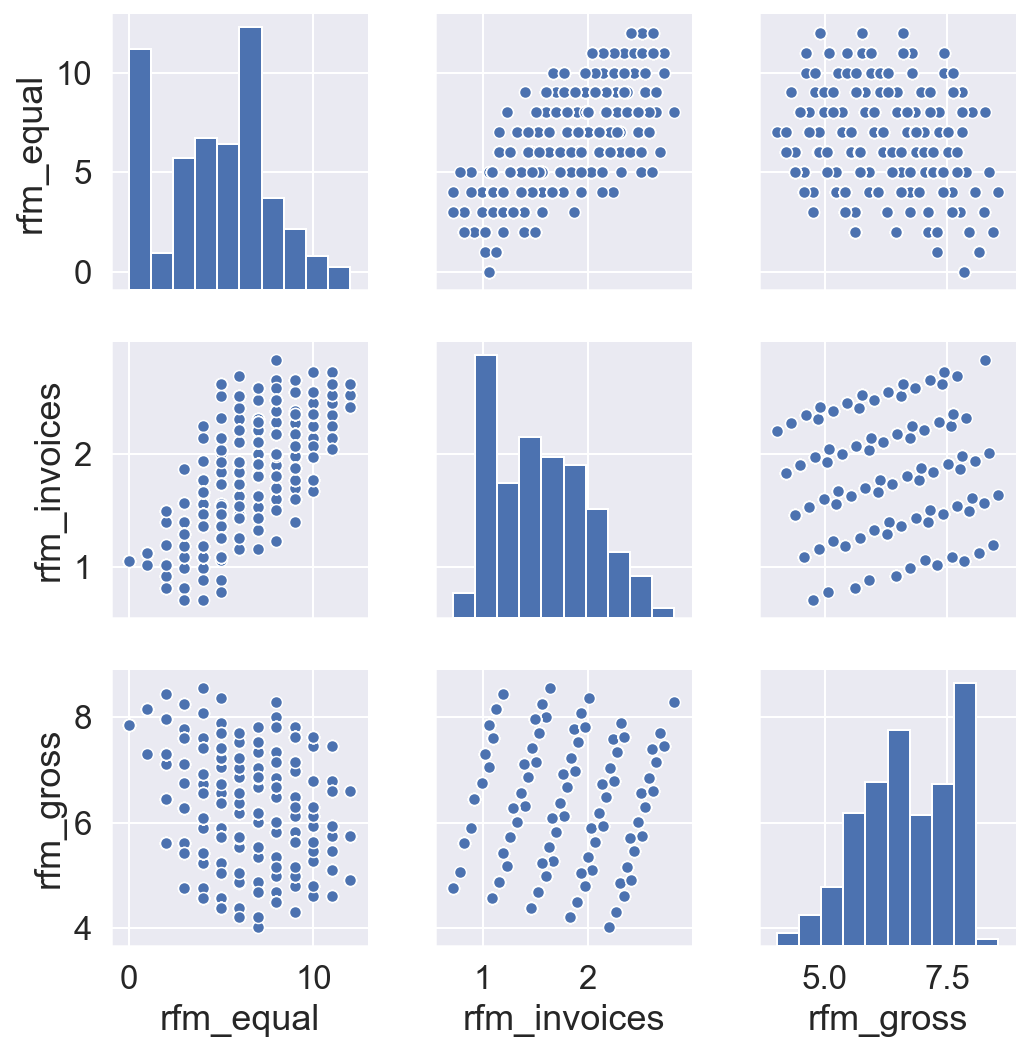

In [65]:
sns.pairplot(df_lower[['rfm_equal', 'rfm_invoices', 'rfm_gross']]);